In [ ]:
import requests
import pandas as pd

# Define the API endpoint and parameters
url = 'https://api.binance.com/api/v3/klines'
params = {
    'symbol': 'ETHUSDT',  # Replace with the desired trading pair
    'interval': '1h',     # Options: 1m, 3m, 5m, etc.
    'startTime' : 1722470400000,
    # 'endTime' : '',
    'limit': 500
}

# Make the HTTP GET request
response = requests.get(url, params=params)
data = response.json()

# Check for errors
if response.status_code != 200:
    print(f"Error fetching data: {data['msg']}")
    exit()

# Create a DataFrame and assign column names
columns = [
    'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Close time', 'Quote asset volume', 'Number of trades',
    'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'
]
df = pd.DataFrame(data, columns=columns)

# Convert timestamps to datetime
df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')

# Convert numeric columns to appropriate data types
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume',
                   'Quote asset volume', 'Taker buy base asset volume',
                   'Taker buy quote asset volume']
df[numeric_columns] = df[numeric_columns].astype(float)

# Display the DataFrame
print(df.head())


In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume',
                   'Quote asset volume', 'Taker buy base asset volume',
                   'Taker buy quote asset volume']
df[numeric_columns] = df[numeric_columns].astype(float)
df = df.sort_values('Open time')


# Prepare the data
data = df[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

training_size = int(len(X) * 0.8)

X_train = X[:training_size]
y_train = y[:training_size]
X_test = X[training_size:]
y_test = y[training_size:]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


In [25]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_scaled = scaler.inverse_transform(y_pred)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#  Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

Root Mean Squared Error: 27.352134786538798
Mean Absolute Error: 22.37566084428266


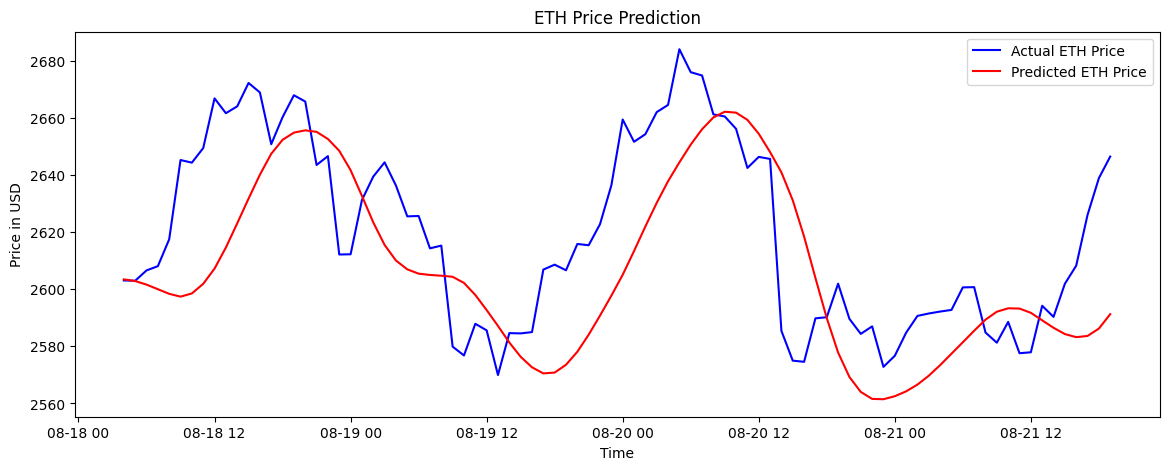

In [27]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(14,5))
plt.plot(df['Open time'][len(df) - len(y_test_scaled):], y_test_scaled, color='blue', label='Actual ETH Price')
plt.plot(df['Open time'][len(df) - len(y_test_scaled):], y_pred_scaled, color='red', label='Predicted ETH Price')
plt.title('ETH Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.legend()
plt.show()